In [7]:
# use pygmt06 env
import sys
import pygmt
import numpy as np
from numpy import linalg
from numpy.linalg import lstsq

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import axes
import matplotlib.gridspec as gridspec

import statistics as stat
import csv
import pandas as pd

import scipy as sp
from scipy import stats 
from scipy.interpolate import griddata, LinearNDInterpolator, NearestNDInterpolator, Rbf, RectBivariateSpline
from scipy.sparse.linalg import lsqr

import mpl_toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from datetime import date

import scripts.gravbox_with_Nagy_variables #import gravbox_with_Nagy_variable
from scripts.gravbox import gravbox
from scripts.grav_column_der import grav_column_der
from scripts.basemap_interp import Interp

# import GUI program (QtDesign) packages
from PyQt5 import QtGui, QtWidgets
from PyQt5.QtWidgets import QApplication, QMainWindow, QFileDialog, QTextEdit

#import .py geometry file from Qt Designer
import gui_files.grav_bathy_inversion_GUI_geometry    #<---- add .py geometry file

from scipy.ndimage import filters
warnings.filterwarnings('ignore')

In [11]:
cd

C:\Users\matthewt


In [12]:
cd Documents\Python_Scripts\Nagy_inversion_GUI

C:\Users\matthewt\Documents\Python_Scripts\Nagy_inversion_GUI


In [15]:
# FILEGRAVITY = 'ROSETTA_gravity_20k.csv'
# FILEICE = 'BedMachine_surface_filled_20k.csv'
# FILEWATER = 'BedMachine_icebase_filled_20k.csv'
# FILEBATHYMETRY = 'BedMachine_bed_20k.csv'
# FILEBASEMENT = 'ROSETTA_basement_BedMachine_bed_20k.csv'
FILEGRAVITY = 'base_RIS_gravity_10000m_lr.XYZ'
FILEICE = 'base_RIS_ice_10000m_lr.XYZ'
FILEWATER = 'base_RIS_water_10000m_lr.XYZ'
FILEBATHYMETRY = 'base_RIS_layer1_10000m_lr.XYZ'
FILEBASEMENT = 'base_RIS_layer2_20000m_lr.XYZ'
# FILEMOHO = 'data/Flat_Moho.csv'

RESG = 10000
RESI = 10000
RESW = 10000
RESBATH = 10000
RESBASE = 20000
# RESM = 5000

if FILEGRAVITY:
    INPUT_GRAVITY=pd.read_csv(FILEGRAVITY, header=0, index_col=None, sep=',', names=('Y','X','FA','Z','FACP') )
    XG=np.array(INPUT_GRAVITY.X) # 2nd col, Northing = X (geophysics convention?)
    YG=np.array(INPUT_GRAVITY.Y) # 1st col, Easting = Y (geophysics convention?)
    ZG=np.array(INPUT_GRAVITY.Z) # 3rd col, survey elevation
    FA=np.array(INPUT_GRAVITY.FA) # 4th col, Free air grav gridded
    FACP=np.array(INPUT_GRAVITY.FACP) #5th col, Free air grav gridded with only bathy control points
    NG=len(XG)      #<---- gives size of input data file

if FILEICE:
    INPUT_ICE=pd.read_csv(FILEICE, header=0, index_col=None, sep=',', names=('Y','X','Z','RHO','CP') )
    XI=np.array(INPUT_ICE.X) 
    YI=np.array(INPUT_ICE.Y) 
    ZI=np.array(INPUT_ICE.Z) 
    RHOI=np.array(INPUT_ICE.RHO) 
    CPI=np.array(INPUT_ICE.CP) 
    NI=len(XI)
    
if FILEWATER:
    INPUT_WATER=pd.read_csv(FILEWATER, header=0, index_col=None, sep=',', names=('Y','X','Z','RHO','CP') )
    XW=np.array(INPUT_WATER.X) 
    YW=np.array(INPUT_WATER.Y) 
    ZW=np.array(INPUT_WATER.Z) 
    RHOW=np.array(INPUT_WATER.RHO) 
    CPW=np.array(INPUT_WATER.CP) 
    NW=len(XW)

if FILEBATHYMETRY:
    INPUT_BATHYMETRY=pd.read_csv(FILEBATHYMETRY, header=0, index_col=None, sep=',', names=('Y','X','Z','RHO','CP') )
    XBath=np.array(INPUT_BATHYMETRY.X) 
    YBath=np.array(INPUT_BATHYMETRY.Y) 
    ZBath=np.array(INPUT_BATHYMETRY.Z) 
    RHOBath=np.array(INPUT_BATHYMETRY.RHO) 
    CPBath=np.array(INPUT_BATHYMETRY.CP) 
    NBath=len(XBath)         

if FILEBASEMENT:
    INPUT_BASEMENT=pd.read_csv(FILEBASEMENT, header=0, index_col=None, sep=',', names=('Y','X','Z','RHO','CP') )
    XBase=np.array(INPUT_BASEMENT.X) 
    YBase=np.array(INPUT_BASEMENT.Y) 
    ZBase=np.array(INPUT_BASEMENT.Z) 
    RHOBase=np.array(INPUT_BASEMENT.RHO) 
    CPBase=np.array(INPUT_BASEMENT.CP) 
    NBase=len(XBase) 

# if FILEMOHO:
#     INPUT_MOHO=pd.read_csv(FILEMOHO, header=0, index_col=None, sep=',', names=('Y','X','Z','RHO','CP') )
#     XM=np.array(INPUT_MOHO.X) 
#     YM=np.array(INPUT_MOHO.Y) 
#     ZM=np.array(INPUT_MOHO.Z) 
#     RHOM=np.array(INPUT_MOHO.RHO) 
#     CPM=np.array(INPUT_MOHO.CP) 
#     NM=len(XM) 
f"Grav; {NG}, Ice; {NI}, Water; {NW}, Bathy; {NBath}, Base; {NBase}"

'Grav; 3061, Ice; 4655, Water; 4655, Bathy; 4655, Base; 1162'

done counting CPs
done creating CP arrays
done creating index
done indexing Bath
done indexing Base
starting plotting


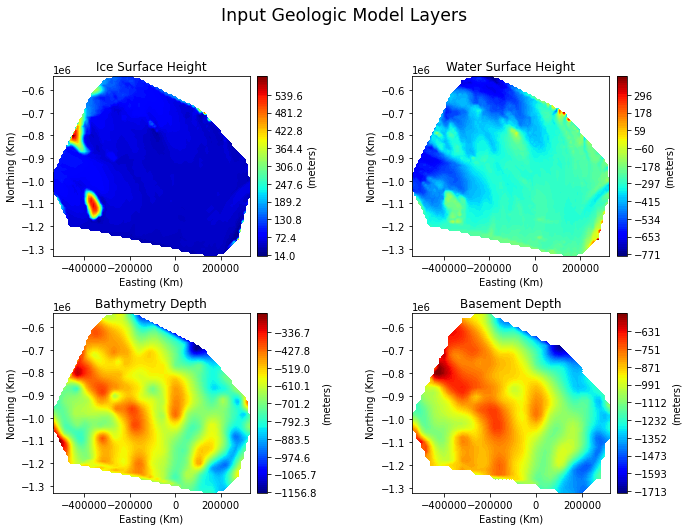

In [16]:
# number of control points in Bathy = sum of all numbers in CPBath (CP=1, non CP=0)
NCPBath = int(np.sum(CPBath))
NCPBase = int(np.sum(CPBase))
# NCPM = int(np.sum(CPM))
print('done counting CPs')
# coords of control points = array of zeros of length total number of control points
XCBath = np.zeros(NCPBath)
YCBath = np.zeros(NCPBath)
XCBase = np.zeros(NCPBase)
YCBase = np.zeros(NCPBase)
# XCM = np.zeros(NCPM)
# YCM = np.zeros(NCPM)
print('done creating CP arrays')
# index of layer = array of zeros of the length of the file
INDEXBath=np.zeros(NBath)
INDEXBase=np.zeros(NBase)
# INDEXM=np.zeros(NM)
print('done creating index')
# 
ICPBath=-1
for i in range(0,NBath):          # iterate over every point in Bath
    if CPBath[i] > 0.5:           # if the control point value is >.5
        ICPBath=ICPBath+1             #
        XCBath[ICPBath]=XBath[i]      # the X and Y coords are added to the respective index of XCBath 
        YCBath[ICPBath]=YBath[i]     
    INDEXBath[i]=i
print('done indexing Bath')
ICPBase=-1
for i in range(0,NBase):
    if CPBase[i] > 0.5:
        ICPBase=ICPBase+1
        XCBase[ICPBase]=XBase[i]
        YCBase[ICPBase]=YBase[i]
    INDEXBase[i]=i
print('done indexing Base')    
# ICPM=-1
# for i in range(0,NM):
#     if CPM[i] > 0.5:
#         ICPM=ICPM+1
#         XCM[ICPM]=XM[i]
#         YCM[ICPM]=YM[i]
#     INDEXM[i]=i
# print('done indexing Moho')
# Gridding / Plotting Input Layers
# plotting in a for-loop
print('starting plotting')
plt.close('all')
for i in range(0,4):#6):
    title = ('Ice Surface Height', 'Water Surface Height', 'Bathymetry Depth', 'Basement Depth')#, 'Moho Depth', 'Obseved Gravity Anomaly')
    label = ('(meters)', '(meters)', '(meters)', '(meters)')#, '(meters)', '(mGals)')
    ax = ('ax1', 'ax2', 'ax3', 'ax4')#, 'ax5', 'ax6')
    ax = list(ax)
    cax = ('cax1', 'cax2', 'cax3', 'cax4')#, 'cax5', 'cax6')
    cax = list(cax)
    img = ('img1', 'img2', 'img3', 'img4')#, 'img5', 'img6')
    img = list(img)
    X = (XI, XW, XBath, XBase)#, XBase, XM, XG)
    Y = (YI, YW, YBath, YBase)#, YM, YG)
    Z = (ZI, ZW, ZBath, ZBase)#, ZM, FA)
    RES = (RESI, RESW, RESBATH, RESBASE)#, RESM, RESG)
    XC = (XCBath, XCBase)#, XCM)
    YC = (YCBath, YCBase)#, YCM)

    X_range=np.arange(min(X[i]),max(X[i])+0.0001,RES[i])
    Y_range=np.arange(min(Y[i]),max(Y[i])+0.0001,RES[i])
    East_grid, North_grid = np.meshgrid(Y_range,X_range)

    extent = x_min, x_max, y_min, y_max= [min(Y[i]), max(Y[i]), min(X[i]), max(X[i])]
    grid_Z = griddata((Y[i], X[i]), Z[i], (East_grid, North_grid), method='linear')

    fig1 = plt.figure(1, (10,10))
    ax[i] = fig1.add_subplot(3,2,i+1, adjustable='box', aspect=1)
    if i == 5:
        img[i] = ax[i].contourf(grid_Z, 100, cmap='jet', extent=extent)
    else:
        img[i] = ax[i].contourf(grid_Z, 100, cmap='jet', extent=extent)
    
    # try:
        # ax[i].plot(YC[i], XC[i], 'ko', markersize=2)
    # except:
    #     pass

    ax[i].set_title(title[i])
    ax[i].set_xlabel('Easting (Km)')
    ax[i].set_ylabel('Northing (Km)')

    divider  = make_axes_locatable(ax[i])
    cax[i] = divider.append_axes('right', size='5%', pad = 0.1)
    cb1 = fig1.colorbar(img[i], label=label[i], cax=cax[i])
    try:
        cb1.set_ticks( ticks = np.arange(min(Z[i]), max(Z[i]), (abs(max(Z[i])-min(Z[i])))/10))
    except:
        pass
plt.suptitle('Input Geologic Model Layers', fontsize='xx-large', y=1.02) 
plt.tight_layout()
plt.show()


In [17]:
# fig = pygmt.Figure()
# with fig.subplot(
#     nrows=3,
#     ncols=2,
#     figsize=("20c", "30c"),
#     sharex=True,
#     sharey=True,
#     autolabel='+ggrey',
#     #frame=["af", "WsNe"],
#     margins=["2c", ".4c"],
#     title="Input Grids"):
#     fig.basemap(region='-760000/600000/-1600000/-240000', frame=["af", "wsne"], projection="X?", panel=[0, 0])
#     fig.grdimage(grid ='data/SURFACE_1k.tif', cmap ='globe', shading='grdgradient+a45/45+nt1+m0', B='+t"Surface"', nan_transparent=True, panel=[0, 0])
#     fig.colorbar(cmap=True, position="JMR+o1c/0c+w7c/0.5c",frame=["x","y+lmeters"])
    
#     fig.basemap(region='-760000/600000/-1600000/-240000', frame=["af", "wsne"], projection="X?", panel=[0, 1])
#     fig.grdimage(grid ='data/ICEBASE_1k.tif', cmap ='globe', shading='grdgradient+a45/45+nt1+m0', B='+t"Icebase"',nan_transparent=True, panel=[0, 1])
#     fig.colorbar(cmap=True, position="JMR+o1c/0c+w7c/0.5c",frame=["x","y+lmeters"])
    
#     fig.basemap(region='-760000/600000/-1600000/-240000', frame=["af", "wsne"], projection="X?", panel=[1, 0])
#     fig.grdimage(grid ='data/BED_5k.tif', cmap ='globe', shading='grdgradient+a45/45+nt1+m0', B='+t"Bed"',nan_transparent=True, panel=[1, 0])
#     fig.colorbar(cmap=True, position="JMR+o1c/0c+w7c/0.5c",frame=["x","y+lmeters"])
    
#     fig.basemap(region='-760000/600000/-1600000/-240000', frame=["af", "wsne"], projection="X?", panel=[1, 1])
#     fig.grdimage(grid ='data/BASEMENT_5k.tif', cmap ='globe', shading='grdgradient+a45/45+nt1+m0', B='+t"Basement"',nan_transparent=True, panel=[1, 1])
#     fig.colorbar(cmap=True, position="JMR+o1c/0c+w7c/0.5c",frame=["x","y+lmeters"])
    
#     fig.basemap(region='-760000/600000/-1600000/-240000', frame=["af", "wsne"], projection="X?", panel=[2, 0])
#     fig.grdimage(grid ='data/MOHO_5k.tif', cmap ='globe', shading='grdgradient+a45/45+nt1+m0', B='+t"Moho"',nan_transparent=True, panel=[2, 0])
#     fig.colorbar(cmap=True, position="JMR+o1c/0c+w7c/0.5c",frame=["x","y+lmeters"])
    
#     fig.basemap(region='-760000/600000/-1600000/-240000', frame=["af", "wsne"], projection="X?", panel=[2, 1])
#     pygmt.grd2cpt(grid ='data/GRAV_50k.nc', cmap ='seis')
#     fig.grdimage(grid ='data/GRAV_50k.nc', cmap =True, shading='grdgradient+a45/45+nt1+m0', B='+t"Free Air Gravity"',nan_transparent=True, panel=[2, 1])
#     fig.colorbar(cmap=True, position="JMR+o1c/0c+w7c/0.5c",frame=["x","y+lmGals"])
# fig.show()


In [18]:
# TREND_TYPE = "Constant value"
TEND_TYPE = 'Other'

# Gridding Residual Gravity Anomaly

# gridding preliminary data
XG_range=np.arange(min(XG),max(XG)+0.0001,RESG)
YG_range=np.arange(min(YG),max(YG)+0.0001,RESG)
East_gridG, North_gridG = np.meshgrid(YG_range,XG_range)

RHOIGRID=griddata((YI,XI),RHOI,(East_gridG, North_gridG), method='linear')
I_GRID=griddata((YI,XI),ZI,(East_gridG, North_gridG), method='linear')
print('gridded Ice')
RHOWGRID=griddata((YW,XW),RHOW,(East_gridG, North_gridG), method='linear')
W_GRID=griddata((YW,XW),ZW,(East_gridG, North_gridG), method='linear')
print('gridded Water')
RHOBathGRID=griddata((YBath,XBath),RHOBath,(East_gridG, North_gridG), method='linear')
Bath_GRID=griddata((YBath,XBath),ZBath,(East_gridG, North_gridG), method='linear')
print('gridded Sediment')
RHOBaseGRID=griddata((YBase,XBase),RHOBase,(East_gridG, North_gridG), method='linear')
Base_GRID=griddata((YBase,XBase),ZBase,(East_gridG, North_gridG), method='linear')
print('gridded Crust')
# M_GRID=griddata((YM,XM),ZM,(East_gridG, North_gridG), method='linear')
# print('gridded Mantle')

gridded Ice
gridded Water
gridded Sediment
gridded Crust


In [19]:
# building vector of control points
# number of control points in Bathy = sum of all numbers in CPBath (CP=1, non CP=0)
NCPBath = int(np.sum(CPBath))
NCPBase = int(np.sum(CPBase))
# NCPM = int(np.sum(CPM))

# coords of control points = array of zeros of length total number of control points
XCBath = np.zeros(NCPBath)
YCBath = np.zeros(NCPBath)
XCBase = np.zeros(NCPBase)
YCBase = np.zeros(NCPBase)
# XCM = np.zeros(NCPM)
# YCM = np.zeros(NCPM)

# index of layer = array of zeros of the length of the file
INDEXBath=np.zeros(NBath)
INDEXBase=np.zeros(NBase)
# INDEXM=np.zeros(NM)

ICPBath=-1
for i in range(0,NBath):          # iterate over every point in Bath
    if CPBath[i] > 0.5:           # if the control point value is >.5
        ICPBath=ICPBath+1             #
        XCBath[ICPBath]=XBath[i]      # the X and Y coords are added to the respective index of XCBath 
        YCBath[ICPBath]=YBath[i]     
    INDEXBath[i]=i

ICPBase=-1
for i in range(0,NBase):
    if CPBase[i] > 0.5:
        ICPBase=ICPBase+1
        XCBase[ICPBase]=XBase[i]
        YCBase[ICPBase]=YBase[i]
    INDEXBase[i]=i 
# ICPM=-1
# for i in range(0,NM):
#     if CPM[i] > 0.5:
#         ICPM=ICPM+1
#         XCM[ICPM]=XM[i]
#         YCM[ICPM]=YM[i]
#     INDEXM[i]=i

NGX=XG_range.size
NGY=YG_range.size

XGRIDVEC=np.zeros([NGX*NGY])
YGRIDVEC=np.zeros([NGX*NGY])

I_GRIDVEC=np.zeros([NGX*NGY])
W_GRIDVEC=np.zeros([NGX*NGY])
Bath_GRIDVEC=np.zeros([NGX*NGY])
Base_GRIDVEC=np.zeros([NGX*NGY])
# M_GRIDVEC=np.zeros([NGX*NGY])

RHOIGRIDVEC=np.zeros([NGX*NGY])
RHOWGRIDVEC=np.zeros([NGX*NGY])
RHOBathGRIDVEC=np.zeros([NGX*NGY])
RHOBaseGRIDVEC=np.zeros([NGX*NGY])
#RHOMGRIDVEC=np.zeros([NGX*NGY])   # ???? not sure if I need this for the last layer (Moho)

INDGRID=-1
for ix in range(0,NGX):
    for iy in range(0,NGY):
        INDGRID=INDGRID+1
        XGRIDVEC[INDGRID]=North_gridG[ix,iy]
        YGRIDVEC[INDGRID]=East_gridG[ix,iy]
        RHOIGRIDVEC[INDGRID]=RHOIGRID[ix,iy]
        RHOWGRIDVEC[INDGRID]=RHOWGRID[ix,iy]
        RHOBathGRIDVEC[INDGRID]=RHOBathGRID[ix,iy]
        RHOBaseGRIDVEC[INDGRID]=RHOBaseGRID[ix,iy]
        # RHOMGRIDVEC[INDGRID]=RHOMGRID[ix,iy]     # ???? not sure if I need this for the last layer (Moho)
        I_GRIDVEC[INDGRID]=I_GRID[ix,iy]
        W_GRIDVEC[INDGRID]=W_GRID[ix,iy]
        Bath_GRIDVEC[INDGRID]=-Bath_GRID[ix,iy]
        Base_GRIDVEC[INDGRID]=-Base_GRID[ix,iy]
        # M_GRIDVEC[INDGRID]=-M_GRID[ix,iy]     # ???? not sure if I need this for the last layer (Moho)

GRID_POINTS=np.zeros([NGX*NGY,2])
GRID_POINTS[:,0]=YGRIDVEC
GRID_POINTS[:,1]=XGRIDVEC

# Density 
intfunDENSI=LinearNDInterpolator(GRID_POINTS,RHOIGRIDVEC)
RHOI_W=intfunDENSI(YW,XW)
RHOI_W[np.isnan(RHOI_W)]=np.mean(RHOI_W[np.isfinite(RHOI_W)])

intfunDENSW=LinearNDInterpolator(GRID_POINTS,RHOWGRIDVEC)
RHOW_Bath=intfunDENSW(YBath,XBath)
RHOW_Bath[np.isnan(RHOW_Bath)]=np.mean(RHOW_Bath[np.isfinite(RHOW_Bath)])

intfunDENSBath=LinearNDInterpolator(GRID_POINTS,RHOBathGRIDVEC)
RHOBath_Base=intfunDENSBath(YBase,XBase)
RHOBath_Base[np.isnan(RHOBath_Base)]=np.mean(RHOBath_Base[np.isfinite(RHOBath_Base)])

# intfunDENSBase=LinearNDInterpolator(GRID_POINTS,RHOBaseGRIDVEC)
# RHOBase_M=intfunDENSBase(YM,XM)
# RHOBase_M[np.isnan(RHOBase_M)]=np.mean(RHOBase_M[np.isfinite(RHOBase_M)])

#  other ??        
intfunI=LinearNDInterpolator(GRID_POINTS,I_GRIDVEC)
Ice=intfunI(YG,XG) 

intfunW=LinearNDInterpolator(GRID_POINTS,W_GRIDVEC)
Water=intfunW(YG,XG) 

intfunBath=LinearNDInterpolator(GRID_POINTS,Bath_GRIDVEC)
Bathymetry=intfunBath(YG,XG) 

intfunBase=LinearNDInterpolator(GRID_POINTS,Base_GRIDVEC)
Basement=intfunBase(YG,XG) 

# intfunM=LinearNDInterpolator(GRID_POINTS,M_GRIDVEC)
# Moho=intfunM(YG,XG) 

# ???????????????????????
# calculate regional gravity field from control points
print("Calculating regional gravity field from control points \n")
    # creating new arrays full of zeros of length NG
FA_CPI=np.zeros(NG)
FA_CPW=np.zeros(NG)
FA_CPBath=np.zeros(NG)
FA_CPBase=np.zeros(NG)
# FA_CPM=np.zeros(NG)
FA_CP_Tot=np.zeros(NG)

Z2I=0*ZI
Z2W=0*ZW
Z2Bath=0*ZBath
Z2Base=0*ZBase
# Z2M=0*ZM

Calculating regional gravity field from control points 



In [20]:
RHOW_Bath

array([1.03, 1.03, 1.03, ..., 1.03, 1.03, 1.03])

In [21]:
for i in range(0,NG):
#     print (i, NG)
    # going through gravity data point by point, for each point sum up the result of the function: gravbox
    if np.round(i/NG, decimals=3)==.25:
        print("25% done")
    elif np.round(i/NG, decimals=3)==.50:
        print("50% done")
    elif np.round(i/NG, decimals=3)==.75:
        print("75% done")
    FA_CPI[i]=np.sum(gravbox(XG[i],    # x0 # sum function will cycle through all of the points in the layer
                                YG[i],    # y0
                                ZG[i],    # z0
                                XI-0.5*RESI, # x1
                                XI+0.5*RESI, # x2
                                YI-0.5*RESI, # y1
                                YI+0.5*RESI, # y2
                                ZI,         # Z
                                Z2I,         # z2
                                RHOI         # rho
                                ))
    FA_CPW[i]=np.sum(gravbox(XG[i],
                                YG[i],
                                ZG[i],
                                XW-0.5*RESW,
                                XW+0.5*RESW,
                                YW-0.5*RESW,
                                YW+0.5*RESW,
                                ZW,
                                Z2W,
                                RHOW-RHOI_W
                                ))
    FA_CPBath[i]=np.sum(gravbox(XG[i],
                                   YG[i],
                                   ZG[i],
                                   XBath-0.5*RESBATH,
                                   XBath+0.5*RESBATH,
                                   YBath-0.5*RESBATH,
                                   YBath+0.5*RESBATH,
                                   ZBath,
                                   Z2Bath,
                                   RHOBath-RHOW_Bath
                                   ))
    FA_CPBase[i]=np.sum(gravbox(XG[i],
                                   YG[i],
                                   ZG[i],
                                   XBase-0.5*RESBASE,
                                   XBase+0.5*RESBASE,
                                   YBase-0.5*RESBASE,
                                   YBase+0.5*RESBASE,
                                   ZBase,
                                   Z2Base,
                                   RHOBase-RHOBath_Base
                                   ))
    # FA_CPM[i]=np.sum(gravbox(XG[i],
    #                             YG[i],
    #                             ZG[i],
    #                             XM-0.5*RESM,
    #                             XM+0.5*RESM,
    #                             YM-0.5*RESM,
    #                             YM+0.5*RESM,
    #                             ZM,
    #                             Z2M,
    #                             RHOM-RHOBase_M
    #                             ))
    FA_CP_Tot = - FA_CPI - FA_CPW + FA_CPBath# + FA_CPBase + FA_CPM

FA_DCP = FACP - FA_CP_Tot
TREND_TYPE='Constant value'
if TREND_TYPE=="Constant value":
    FA_Regional=np.nanmean(FA_DCP)*np.ones([NG])    # changed mp.mean to np.nanmean to fix issue of not griding Regional or Residual when layers had different cell sizes
else:
    ATEMP=np.lib.column_stack((np.ones(XG.size), XG, YG))
    C,RESID,RANK,SIGMA=linalg.lstsq(ATEMP,FA_DCP)
    FA_Regional=C[0]*np.ones([NG])+C[1]*XG+C[2]*YG

FA_Residual = FA-FA_Regional

25% done
25% done
25% done
50% done
50% done
50% done
50% done
75% done
75% done
75% done


In [22]:
FA_Regional

array([-10.53322186, -10.53322186, -10.53322186, ..., -10.53322186,
       -10.53322186, -10.53322186])

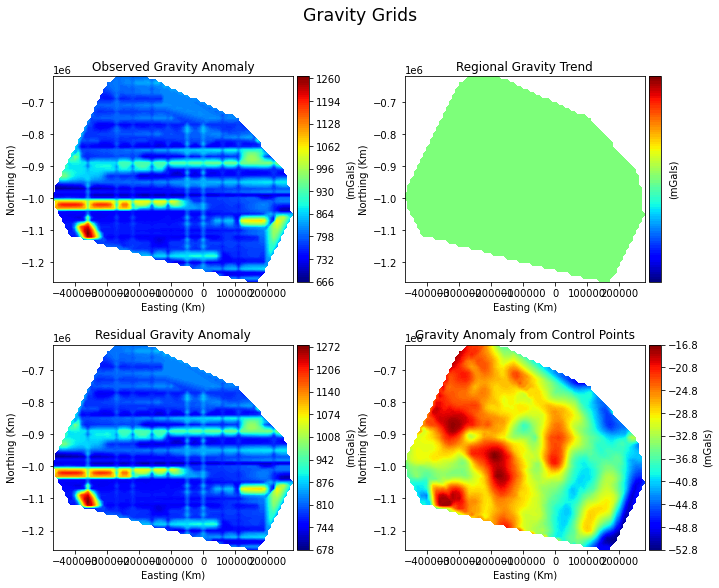

Done Plotting Gravity Grids



In [23]:
# Plotting Gravity Grids

# plotting in a for-loop
for i in range(0,4):
    title = ('Observed Gravity Anomaly', 'Regional Gravity Trend', 'Residual Gravity Anomaly', 'Gravity Anomaly from Control Points')
    ax = ('ax1', 'ax2', 'ax3', 'ax4')
    ax = list(ax)
    cax = ('cax1', 'cax2', 'cax3', 'cax4')
    cax = list(cax)
    img = ('img1', 'img2', 'img3', 'img4')
    img = list(img)

    Z = (FA, FA_Regional, FA_Residual, FA_CP_Tot)

    XG_range=np.arange(min(XG),max(XG)+0.0001,RESG)
    YG_range=np.arange(min(YG),max(YG)+0.0001,RESG)
    East_gridG, North_gridG = np.meshgrid(YG_range,XG_range)
    extentG = xG_min, xG_max, yG_min, yG_max = [min(YG), max(YG), min(XG), max(XG)]

    grid_Z = griddata((YG, XG), Z[i], (East_gridG, North_gridG), method='linear')

    fig2 = plt.figure(2, (10,8))
    ax[i] = fig2.add_subplot(2,2,i+1, adjustable='box', aspect=1)
    img[i] = ax[i].contourf(grid_Z, 100, cmap='jet', extent=extentG)
    ax[i].set_title(title[i])
    ax[i].set_xlabel('Easting (Km)')
    ax[i].set_ylabel('Northing (Km)')
#     ax[i].set_ylim(-1340000,-540000)
#     ax[i].set_xlim(-495000,305000)
#     ax[i].set_yticks( ticks = np.arange(min(XI)+30000, max(XI)+30000, 100000))
#     ax[i].set_yticklabels(labels = np.arange(int(0.001*(min(XI)+30000)), int(0.001*(max(XI)+30000)), int(100)))
#     ax[i].set_xticks( ticks = np.arange(min(YI+40000), max(YI)+40000, 200000))
#     ax[i].set_xticklabels(labels = np.arange(int(0.001*(min(YI)+40000)), int(0.001*(max(YI)+40000)), int(200)))

    divider  = make_axes_locatable(ax[i])
    cax[i] = divider.append_axes('right', size='5%', pad = 0.05)
    cb2 = fig2.colorbar(img[i], label='(mGals)', cax=cax[i])
    if i==1:
         cb2.set_ticks( ticks = np.arange(0,1,1))
    else:
        #cb2.set_ticks( ticks = np.arange(min(Z[i]), max(Z[i]), (abs(max(Z[i])-min(Z[i])))/10))
        #cb2.set_ticks( ticks = np.arange(min(Z[i]), max(Z[i]), (abs(max(Z[i])-min(Z[i])))/10))
        pass
#plt.subplots_adjust(left=2, bottom=2, right=20, top=20)
plt.suptitle('Gravity Grids', fontsize='xx-large', y=1.02)   
plt.tight_layout()
plt.show()
print('Done Plotting Gravity Grids\n')

In [26]:
# INVERSIONS    

# this will change the layers' surface elevations or densities to minimize gravity misfit between observed and forward model

Min_sed_thickness=100

if 'MATDATPAR' in globals():
    del MATDATPAR
if 'MAT_DENS' in globals():
    del MAT_DENS

ZSGRIDVEC=np.zeros([NGX*NGY])

Tolerance_Bathymetry=100 
Tolerance_Basement=100
# Tolerance_Moho=0

Tolerance_Bathymetry_Contraints=100
Tolerance_Basement_Contraints=100
# Tolerance_Moho_Constraints=0

Density_Sediment_Variation=0
Density_Crust_Variation=0
# Density_Mantle_Variation=0

Least_Squares=0.001
Tolerance_Least_Squares=0.02
Max_Iterations=50

Z_Corrected_Bathymetry=ZBath
Z_Bath_Base = np.concatenate((ZBath,ZBase))#,ZM))
RHO_Bath_Base = np.concatenate((RHOBath,RHOBase))#,RHOM))

MATDATPAR = (np.zeros([NG,NBath+NBase]))#+NM])) # array with NG number of rows and NBath+NBase+NM number of columns

MAT_DENS = (np.zeros([NG,NBath+NBase]))#+NM]))

FA_Inversion = FA - FA_Regional 
Grav_Misfit=np.zeros([NG])        

CHISQ1=np.Inf  # positive infinity
DCHISQ=np.Inf  # positibe infinity

ITER=0
print("Executing iteration "+str(ITER+1)) 
while DCHISQ > 1+Tolerance_Least_Squares: # while DCHISQ is greater than 1 + least squares tolerance (0.02)
    ITER=ITER+1 
    print("iteration", ITER)
    FA_Forward=np.zeros([NG])    
    FA_Forward_Bath=np.zeros([NG])
    FA_Forward_Base=np.zeros([NG])
    # FA_Forward_Moho=np.zeros([NG])
    for i in range(0,NG):  
        # for each gravity station, will sum up the gravity contributions from each layer's points and add it to a file for each layer
        if np.round(i/NG, decimals=3)==.25:
            print("25% done")
        elif np.round(i/NG, decimals=3)==.50:
            print("50% done")
        elif np.round(i/NG, decimals=3)==.75:
            print("75% done")
        else:
            pass
        FA_Forward_Bath[i]=np.sum(gravbox(XG[i],YG[i],ZG[i],
                                          XBath-0.5*RESBATH,
                                          XBath+0.5*RESBATH,
                                          YBath-0.5*RESBATH,
                                          YBath+0.5*RESBATH,    
                                          Z_Bath_Base[0:NBath],    
                                          Z2Bath,    
                                          RHO_Bath_Base[0:NBath] - RHOW_Bath
                                         )) 
        FA_Forward_Base[i]=np.sum(gravbox(XG[i],YG[i],ZG[i],     
                                          XBase-0.5*RESBASE,
                                          XBase+0.5*RESBASE,
                                          YBase-0.5*RESBASE,
                                          YBase+0.5*RESBASE,     
                                          Z_Bath_Base[NBath:NBath+NBase],    
                                          Z2Base,     
                                          RHO_Bath_Base[NBath:NBath+NBase] - RHOBath_Base))
        # FA_Forward_Moho[i]=np.sum(gravbox(XG[i],YG[i],ZG[i],   
        #                                   XM-0.5*RESM,
        #                                   XM+0.5*RESM,
        #                                   YM-0.5*RESM,
        #                                   YM+0.5*RESM,    
        #                                   Z_Bath_Base_Moho[NBath+NBase:NBath+NBase+NM],    
        #                                   Z2M,     
        #                                   RHO_Bath_Base_Moho[NBath+NBase:NBath+NBase+NM] - RHOM-RHOBase_M))

        FA_Forward=FA_Forward_Bath+FA_Forward_Base#+FA_Forward_Moho 

        #MATDATPAR is matrix array with NG number of rows and NBath+NBase+NM number of columns
        # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
        #SURFACE ELEVATION
        MATDATPAR[i,0:NBath]=grav_column_der(XG[i], YG[i], ZG[i],     
                                             XBath,
                                             YBath,     
                                             Z_Bath_Base[0:NBath],
                                             Z2Bath,     
                                             RESBATH,     
                                             RHOBath-RHOW_Bath)  # MATDATPAR[i,0:NBath] is i'th row and columns 0 to NBath
        MATDATPAR[i,NBath:NBath+NBase]=grav_column_der(XG[i], YG[i], ZG[i],     
                                                       XBase,
                                                       YBase,     
                                                       Z_Bath_Base[NBath:NBath+NBase],
                                                       Z2Base,     
                                                       RESBASE,     
                                                       RHOBase-RHOBath_Base)
        # MATDATPAR[i,NBath+NBase:NBath+NBase+NM]=grav_column_der(XG[i], YG[i], ZG[i],
        #                                                         XM,
        #                                                         YM,     
        #                                                         Z_Bath_Base[NBath+NBase:NBath+NBase+NM],
        #                                                         Z2M,     
        #                                                         RESM,      
        #                                                         RHOM-RHOBase_M)
        # #DENSITY
        MAT_DENS[i,0:NBath]=grav_column_der(XG[i], YG[i], ZG[i],      
                                            XBath,
                                            YBath,     
                                            Z_Bath_Base[0:NBath],     
                                            Z2Bath,     
                                            RESBATH,     
                                            RHOBath-RHOW_Bath)
        MAT_DENS[i,NBath:NBath+NBase]=grav_column_der(XG[i], YG[i], ZG[i],      
                                                      XBase,
                                                      YBase,     
                                                      Z_Bath_Base[NBath:NBath+NBase],    
                                                      Z2Base,      
                                                      RESBASE,      
                                                      RHOBase-RHOBath_Base)
        # MAT_DENS[i,NBath+NBase:NBath+NBase+NM]=grav_column_der(XG[i], YG[i], ZG[i],      
        #                                                        XM,
        #                                                        YM,      
        #                                                        Z_Bath_Base[NBath+NBase:NBath+NBase+NM],    
        #                                                        Z2M,      
        #                                                        RESM,       
        #                                                        RHOM-RHOBase_M)

    Grav_Misfit=FA_Inversion-FA_Forward # this is = FA - FA_Regional - FA_Forward

    # gives the amount that each column's Z1 needs to change by to have the smallest misfit
    Surface_correction=lsqr(MATDATPAR,Grav_Misfit,show=False)[0] # finds the least-squares solution to MATDATPAR and Grav_Misfit, assigns the first value to Surface_correction
    # gives the amount that each column's density needs to change by to have the smallest misfit
    Density_correction=-lsqr(MAT_DENS,Grav_Misfit,show=False)[0]


    # if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Surface_correction
    for i in range(0,NBath):
        if Surface_correction[i] > Tolerance_Bathymetry:
            Surface_correction[i]=Tolerance_Bathymetry
        elif Surface_correction[i] < -Tolerance_Bathymetry:
            Surface_correction[i]=-Tolerance_Bathymetry
    for i in range(NBath,NBath+NBase):
        if Surface_correction[i] > Tolerance_Basement:
            Surface_correction[i]=Tolerance_Basement
        elif Surface_correction[i] < -Tolerance_Basement:
            Surface_correction[i]=-Tolerance_Basement   
    # for i in range(NBath+NBase,NBath+NBase+NM):
    #     if Surface_correction[i] > Tolerance_Moho:
    #         Surface_correction[i]=Tolerance_Moho
    #     elif Surface_correction[i] < -Tolerance_Moho:
    #         Surface_correction[i]=-Tolerance_Moho

    # if necesarry correction in greater than density tolerance, then correction equals tolerance, if it's less than density tolerance, then correct by Density_correction
    for i in range(0,NBath):
        if Density_correction[i] > Density_Sediment_Variation:
            Density_correction[i]=Density_Sediment_Variation
        elif Density_correction[i] < -Density_Sediment_Variation:
            Density_correction[i]=-Density_Sediment_Variation   
    for i in range(NBath,NBath+NBase):
        if Density_correction[i] > Density_Crust_Variation:
            Density_correction[i]=Density_Crust_Variation
        elif Density_correction[i] < -Density_Crust_Variation:
            Density_correction[i]=-Density_Crust_Variation
    # for i in range(NBath+NBase,NBath+NBase+NM):
    #     if Density_correction[i] > Density_Mantle_Variation:
    #         Density_correction[i]=Density_Mantle_Variation
    #     elif Density_correction[i] < -Density_Mantle_Variation:
    #         Density_correction[i]=-Density_Mantle_Variation

    # resetting the Z values with the above corrections 
    Z_Bath_Base=Z_Bath_Base+Surface_correction
    Z_Corrected_Bathymetry=Z_Bath_Base[0:NBath]   
    Z_Corrected_Basement=Z_Bath_Base[NBath:NBath+NBase]
    # Z_Corrected_Moho=Z_Bath_Base[NBath+NBase:NBath+NBase+NM]
    # resetting the RHO values with the above corrections 
    RHO_Bath_Base=RHO_Bath_Base+Density_correction
    RHOSBathymetry=RHO_Bath_Base[0:NBath]   
    RHOSBasement=RHO_Bath_Base[NBath:NBath+NBase]
    # RHOSMoho=RHO_Bath_Base[NBath+NBase:NBath+NBase+NM]

    # if change at constrains is greater than allowed, force to be the max amount
    for i in range(0,NBath):
        if CPBath[i]==1:
            if Z_Corrected_Bathymetry[i] > ZBath[i]+Tolerance_Bathymetry_Contraints:
                Z_Corrected_Bathymetry[i]=ZBath[i]+Tolerance_Bathymetry_Contraints
            elif Z_Corrected_Bathymetry[i] < ZBath[i]-Tolerance_Bathymetry_Contraints:
                Z_Corrected_Bathymetry[i]=ZBath[i]-Tolerance_Bathymetry_Contraints
    for i in range(0,NBase):
        if CPBase[i]==1:
            if Z_Corrected_Basement[i] > ZBase[i]+Tolerance_Basement_Contraints:
                Z_Corrected_Basement[i]=ZBase[i]+Tolerance_Basement_Contraints
            elif Z_Corrected_Basement[i] < ZBase[i]-Tolerance_Basement_Contraints:
                Z_Corrected_Basement[i]=ZBase[i]-Tolerance_Basement_Contraints
    # for i in range(0,NM):
    #     if CPM[i]==1:
    #         if Z_Corrected_Moho[i] > ZM[i]+Tolerance_Moho_Constraints:
    #             Z_Corrected_Moho[i]=ZM[i]+Tolerance_Moho_Constraints
    #         elif Z_Corrected_Moho[i] < ZM[i]-Tolerance_Moho_Constraints:
    #             Z_Corrected_Moho[i]=ZM[i]-Tolerance_Moho_Constraints 

    # incase layers are of different resolution, need to project corrected Z1 values onto lower layer's resolution
    # for basement
    Z_Corrected_Bathymetry_Grid=griddata((YBath, XBath), Z_Corrected_Bathymetry, (East_gridG, North_gridG), method='linear')            
    index1=-1
    for x in range(0,NGX):
        for y in range(0,NGY):
            index1=index1+1
            Bath_GRIDVEC[index1]=Z_Corrected_Bathymetry_Grid[x,y]       
    intfunZ_Corrected_regrid_Basement=LinearNDInterpolator(GRID_POINTS,Bath_GRIDVEC)
    Z_Bathymetry_reprojected=intfunZ_Corrected_regrid_Basement(YBase,XBase)
        # if basement is the same or above sediment, add min sed thickness to basement
    for i in range(0,NBase):
        if Z_Corrected_Basement[i] > Z_Bathymetry_reprojected[i]:
            Z_Corrected_Basement[i] = Z_Bathymetry_reprojected[i]+100

    # # for moho
    # Z_Corrected_Basement_Grid=griddata((YM, XM), Z_Corrected_Basement, (East_gridG, North_gridG), method='linear')              
    # index2=-1
    # for x in range(0,NGX):
    #     for y in range(0,NGY):
    #         index2=index2+1
    #         Base_GRIDVEC[index2]=Z_Corrected_Basement_Grid[x,y]       
    # intfunZ_Corrected_regrid_Moho=LinearNDInterpolator(GRID_POINTS,Base_GRIDVEC)
    # Z_Basement_reprojected=intfunZ_Corrected_regrid_Moho(YM,XM)
    #      # if moho is the same or above basement, add min sed thickness to basement
    # for i in range(0,NM):
    #     if Z_Corrected_Moho[i] > Z_Basement_reprojected[i]:
    #         Z_Corrected_Moho[i] = Z_Basement_reprojected[i]+100

    # for first iteration, divide infinity by mean square of gravity residuals, inversion will stop once this gets to Tolerance_Least_Squares (0.02)
    CHISQ2=np.mean(Grav_Misfit**2)
    DCHISQ=CHISQ1/CHISQ2
    CHISQ1=CHISQ2
    print ('mean of misfit^2 (CHISSQ2)',CHISQ2)
    print("DCHISQ=",DCHISQ)
    print("CHISQ1=",CHISQ1)


    print("Iteration "+ str(ITER)+" terminated with least-squares norm="+str(CHISQ2)+", executing iteration "+str(ITER+1))

    # stop the inversion if hit the max # iterations or it's below the Least Squares norm 
    if ITER==Max_Iterations:
        print("Inversion terminated after "+ str(ITER)+" iterations with least-squares norm="+str(CHISQ2)+ "because maximum number of iterations "+ str(Max_Iterations)+" reached")
        break
    if CHISQ2 < Least_Squares:
        print("Inversion terminated after "+ str(ITER)+" iterations with least-squares norm="+str(CHISQ2)+" because least-squares norm < " + str(Least_Squares))
        break

    # end of inversion iteration WHILE loop

if DCHISQ < 1+Tolerance_Least_Squares:
    print("terminated - no significant variation in least-squares norm ")

Bathymetry_Surface_Diff = ZBath - Z_Corrected_Bathymetry
Basement_Surface_Diff = ZBase - Z_Corrected_Basement
# Moho_Surface_Diff = ZM - Z_Corrected_Moho

Bathymetry_Density_Diff = RHOBath - RHOSBathymetry
Basement_Density_Diff = RHOBase - RHOSBasement
# Moho_Density_Diff = RHOM - RHOSMoho

XBath_range=np.arange(min(XBath),max(XBath)+0.0001,RESBATH)
YBath_range=np.arange(min(YBath),max(YBath)+0.0001,RESBATH)
East_gridBath, North_gridBath = np.meshgrid(YBath_range,XBath_range)

XBase_range=np.arange(min(XBase),max(XBase)+0.0001,RESBASE)
YBase_range=np.arange(min(YBase),max(YBase)+0.0001,RESBASE)
East_gridBase, North_gridBase = np.meshgrid(YBase_range,XBase_range)

# XM_range=np.arange(min(XM),max(XM)+0.0001,RESM)
# YM_range=np.arange(min(YM),max(YM)+0.0001,RESM)
# East_gridM, North_gridM = np.meshgrid(YM_range,XM_range)



Executing iteration 1
iteration 1
25% done
25% done
25% done
50% done
50% done
50% done
50% done
75% done
75% done
75% done
mean of misfit^2 (CHISSQ2) 727677.2481352775
DCHISQ= inf
CHISQ1= 727677.2481352775
Iteration 1 terminated with least-squares norm=727677.2481352775, executing iteration 2
iteration 2
25% done
25% done
25% done
50% done
50% done
50% done
50% done
75% done
75% done
75% done
mean of misfit^2 (CHISSQ2) 715170.6116229384
DCHISQ= 1.0174876264615484
CHISQ1= 715170.6116229384
Iteration 2 terminated with least-squares norm=715170.6116229384, executing iteration 3
terminated - no significant variation in least-squares norm 


IndexError: tuple index out of range

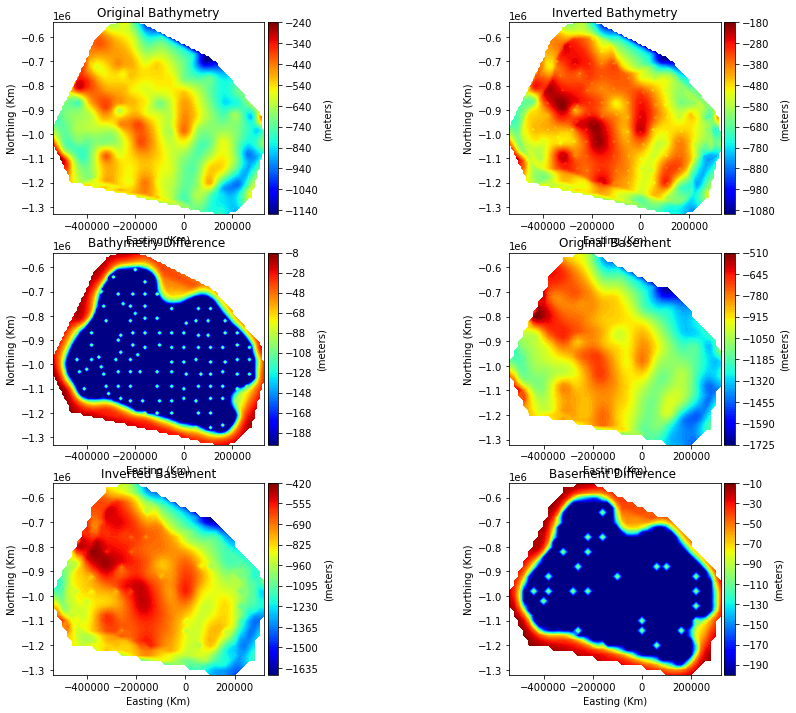

In [27]:
#################################################
# Plotting Inversion Grids
# need 3 figures: 
    # 1: 3x3 with rows: bathy, base, moho,    columns: original, inverted, difference 
    # 2: 3x2 with rows: bathy, base, moho,    columns: original density, new density
    # 3: 3x1 observed grav, forward grav after inversion, misfit

# plotting figure 1 (fig3) in a for-loop
for i in range(0,9):
    title = ('Original Bathymetry', 'Inverted Bathymetry', 'Bathymetry Difference ',
             'Original Basement', 'Inverted Basement', 'Basement Difference '
             # 'Original Moho', 'Inverted Moho', 'Moho Difference'
            )
    ax = ('ax1', 'ax2', 'ax3', 'ax4', 'ax5', 'ax6')#, 'ax7', 'ax8', 'ax9')
    ax = list(ax)
    cax = ('cax1', 'cax2', 'cax3', 'cax4', 'cax5', 'cax6')#, 'cax7', 'cax8', 'cax9')
    cax = list(cax)
    img = ('img1', 'img2', 'img3', 'img4', 'img5', 'img6')#, 'img7', 'img8', 'img9')
    img = list(img)
    Z = (ZBath, Z_Corrected_Bathymetry, Bathymetry_Surface_Diff,
         ZBase, Z_Corrected_Basement, Basement_Surface_Diff, 
         # ZM, Z_Corrected_Moho, Moho_Surface_Diff
        ) 
    X = (XBath, XBath, XBath, 
         XBase, XBase, XBase, 
         # XM, XM, XM
        )
    Y = (YBath, YBath, YBath,
         YBase, YBase, YBase,
         # YM, YM, YM
        ) 
    East_grid = (East_gridBath, East_gridBath, East_gridBath,
                 East_gridBase, East_gridBase, East_gridBase,
                 # East_gridM, East_gridM, East_gridM
                )
    North_grid = (North_gridBath, North_gridBath, North_gridBath,
                  North_gridBase, North_gridBase, North_gridBase,
                  # North_gridM, North_gridM, North_gridM
                 )

    grid_Z = griddata((Y[i], X[i]), Z[i], (East_grid[i], North_grid[i]), method='linear')
    fig3 = plt.figure(3, (15,12))
    ax[i] = fig3.add_subplot(3,2,i+1, adjustable='box', aspect=1)
    extent = x_min, x_max, y_min, y_max= [min(Y[i]), max(Y[i]), min(X[i]), max(X[i])]
    img[i] = ax[i].contourf(grid_Z, 100, cmap='jet', extent=extent)
    ax[i].set_title(title[i])
    ax[i].set_xlabel('Easting (Km)')
    ax[i].set_ylabel('Northing (Km)')
#     ax[i].set_ylim(-1385000,-485000)
#     ax[i].set_xlim(-555000,345000)
#     ax[i].set_yticks( ticks = np.arange(min(XI)+30000, max(XI)+30000, 100000))
#     ax[i].set_yticklabels(labels = np.arange(int(0.001*(min(XI)+30000)), int(0.001*(max(XI)+30000)), int(100)))
#     ax[i].set_xticks( ticks = np.arange(min(YI+40000), max(YI)+40000, 200000))
#     ax[i].set_xticklabels(labels = np.arange(int(0.001*(min(YI)+40000)), int(0.001*(max(YI)+40000)), int(200)))
    divider  = make_axes_locatable(ax[i])
    cax[i] = divider.append_axes('right', size='5%', pad = 0.05)
    cb3 = fig3.colorbar(img[i], label="(meters)", cax=cax[i])
plt.suptitle('Layer Surface - Gravity Inversion', fontsize='xx-large', y=1.02) 
plt.tight_layout()
plt.show()
print('\nDone Plotting Inversion Grids #1\n')

###########################################
 # plotting figure 2 (fig4)in a for-loop

for i in range(0,9):
    title = ('Original Sediment Density', 'Inverted Sediment Density', 'Sediment Density Difference',
             'Original Crust Density', 'Inverted Crust Density', 'Crust Density Difference',
             'Original Mantle Density', 'Inverted Mantle Density', 'Mantle Density Difference')
    ax = ('ax1', 'ax2', 'ax3', 'ax4', 'ax5', 'ax6', 'ax7', 'ax8', 'ax9')
    ax = list(ax)
    cax = ('cax1', 'cax2', 'cax3', 'cax4', 'cax5', 'cax6', 'cax7', 'cax8', 'cax9')
    cax = list(cax)
    img = ('img1', 'img2', 'img3', 'img4', 'img5', 'img6', 'img7', 'img8', 'img9')
    img = list(img)
    Z = (RHOBath, RHOSBathymetry, Bathymetry_Density_Diff,
         RHOBase, RHOSBasement, Basement_Density_Diff, 
         RHOM, RHOSMoho, Moho_Density_Diff) # need to swap in Moho terms  
    X = (XBath, XBath, XBath, 
         XBase, XBase, XBase, 
         XM, XM, XM)
    Y = (YBath, YBath, YBath,
         YBase, YBase, YBase,
         YM, YM, YM) # need to swap in Moho terms
    X_range = (XBath_range, XBath_range, XBath_range,
               XBase_range, XBase_range,  XBase_range,
               XM_range, XM_range, XM_range) # need to swap in Moho terms
    Y_range = (YBath_range, YBath_range, YBath_range,
               YBase_range, YBase_range, YBase_range,
               YM_range, YM_range, YM_range) # need to swap in Moho terms
    East_grid = (East_gridBath, East_gridBath, East_gridBath,
                 East_gridBase, East_gridBase, East_gridBase,
                 East_gridM, East_gridM, East_gridM)
    North_grid = (North_gridBath, North_gridBath, North_gridBath,
                  North_gridBase, North_gridBase, North_gridBase,
                  North_gridM, North_gridM, North_gridM)

    grid_Z = griddata((Y[i], X[i]), Z[i], (East_grid[i], North_grid[i]), method='linear')
    fig4 = plt.figure(4, (15,12))
    ax[i] = fig4.add_subplot(3,3,i+1, adjustable='box', aspect=1)
    extent = x_min, x_max, y_min, y_max= [min(Y[i]), max(Y[i]), min(X[i]), max(X[i])]
    img[i] = ax[i].contourf(grid_Z, 100, cmap='jet', extent=extent)
    ax[i].set_title(title[i])
    ax[i].set_xlabel('Easting (Km)')
    ax[i].set_ylabel('Northing (Km)')
#     ax[i].set_ylim(-1385000,-485000)
#     ax[i].set_xlim(-555000,345000)
#     ax[i].set_yticks( ticks = np.arange(min(XI)+30000, max(XI)+30000, 100000))
#     ax[i].set_yticklabels(labels = np.arange(int(0.001*(min(XI)+30000)), int(0.001*(max(XI)+30000)), int(100)))
#     ax[i].set_xticks( ticks = np.arange(min(YI+40000), max(YI)+40000, 200000))
#     ax[i].set_xticklabels(labels = np.arange(int(0.001*(min(YI)+40000)), int(0.001*(max(YI)+40000)), int(200)))
    divider  = make_axes_locatable(ax[i])
    cax[i] = divider.append_axes('right', size='5%', pad = 0.05)
    cb4 = fig4.colorbar(img[i], label="(g/cm^3)", cax=cax[i])
plt.suptitle('Density - Gravity Inversion', fontsize='xx-large', y=1.02) 
plt.tight_layout()
plt.show()
print('\nDone Plotting Inversion Grid #2\n')

###########################################
 # plotting figure 3 (fig5)in a for-loop
for i in range(0,3):
    title = ('Observed Gravity', 'Forward Gravity Model', 'Gravity Error')
    ax = ('ax1', 'ax2', 'ax3')
    ax = list(ax)
    cax = ('cax1', 'cax2', 'cax3')
    cax = list(cax)
    img = ('img1', 'img2', 'img3')
    img = list(img)
    Z = (FA, FA_Forward+FA_Regional, FA_Inversion-FA_Forward)

    grid_Z = griddata((YG, XG), Z[i], (East_gridG, North_gridG), method='linear')
    fig5 = plt.figure(5, (12,12))
    ax[i] = fig5.add_subplot(3,1,i+1, adjustable='box', aspect=1)
    #extent = x_min, x_max, y_min, y_max= [min(Y[i]), max(Y[i]), min(X[i]), max(X[i])]
    img[i] = ax[i].contourf(grid_Z, 100, cmap='jet', extent=extentG)
    ax[i].set_title(title[i])
    ax[i].set_xlabel('Easting (Km)')
    ax[i].set_ylabel('Northing (Km)')
#     ax[i].set_ylim(-1385000,-485000)
#     ax[i].set_xlim(-555000,345000)
#     ax[i].set_yticks( ticks = np.arange(min(XI)+30000, max(XI)+30000, 100000))
#     ax[i].set_yticklabels(labels = np.arange(int(0.001*(min(XI)+30000)), int(0.001*(max(XI)+30000)), int(100)))
#     ax[i].set_xticks( ticks = np.arange(min(YI+40000), max(YI)+40000, 200000))
#     ax[i].set_xticklabels(labels = np.arange(int(0.001*(min(YI)+40000)), int(0.001*(max(YI)+40000)), int(200)))
#     if i == 2:
#         ax[i].text(-510000, -530000, 'average misfit: '+str(round(np.mean(FA_Inversion-FA_Forward),3)))
#         ax[i].text(-510000, -575000, 'std: '+str(round(stat.stdev(FA_Inversion-FA_Forward),3)))
    divider  = make_axes_locatable(ax[i])
    cax[i] = divider.append_axes('right', size='5%', pad = 0.05)
    cb5 = fig5.colorbar(img[i], label="(mGals)", cax=cax[i])
plt.suptitle('Gravity Inversion Results', fontsize='xx-large', y=1.02) 
plt.tight_layout()
plt.show()
print('\nDone Plotting Inversion Grid #3\n')